In [1]:
import sys
sys.path.append('../src/')

import SRRS
from SRRS import plotting,metrics,vignette,simulate,scoring
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Arc

In [2]:
gc_df = pd.read_csv('../outputs/gene_cell/MOp_peripheral_ReadZs_gene_ontology.csv')
gc_df.head()

,metric,cell_id,num_spots,gene,num_gene_spots,median_rank,score,variance,mouse,sample,replicate,sample_id,ontology
0,peripheral,10000143038275111136124942858811168393,168,Cxcl14,13,67.0,0.209581,0.062617,2,4,1,m2s4,Astro
1,peripheral,10000143038275111136124942858811168393,168,Daam2,23,113.0,-0.341317,0.035146,2,4,1,m2s4,Astro
2,peripheral,10000143038275111136124942858811168393,168,Egfr,6,56.0,0.341317,0.105180,2,4,1,m2s4,Astro
3,peripheral,10000143038275111136124942858811168393,168,Igfbp5,12,44.5,0.479042,0.062329,2,4,1,m2s4,Astro
4,peripheral,10000143038275111136124942858811168393,168,Pdlim5,5,108.0,-0.281437,0.141105,2,4,1,m2s4,Astro


In [3]:
gc_df['ontology'].unique()

array(['Astro', 'L2/3 IT', 'SMC', 'Pvalb', 'L6 CT', 'Oligo', 'L6 IT',
       'Endo', 'L5 IT', 'Lamp5', 'L5/6 NP', 'Sst', 'VLMC', 'L5 ET',
       'L6 IT Car3', 'OPC', 'L6b', 'Vip', 'Sncg'], dtype=object)

In [9]:
filt_gc_df = gc_df[
    #gc_df['sample_id'].eq('m1s2') &
    gc_df['ontology'].isin(['L6 IT','Sst']) &
    gc_df['gene'].eq('Timp3')
]
print(filt_gc_df.shape)
filt_gc_df.head()

(558, 13)


,metric,cell_id,num_spots,gene,num_gene_spots,median_rank,score,variance,mouse,sample,replicate,sample_id,ontology
11066,peripheral,111224926392630212160278934965632123769,1175,Timp3,16,731.5,-0.244463,0.051707,2,4,1,m2s4,Sst
12505,peripheral,112648164421818832458832345016894387743,1017,Timp3,6,349.5,0.313976,0.106825,2,4,1,m2s4,Sst
23358,peripheral,123723356376229754610115939505968724825,1192,Timp3,10,657.5,-0.102435,0.075311,2,4,1,m2s4,Sst
34369,peripheral,136717447085671937120241694290555474406,545,Timp3,9,354.0,-0.297794,0.089902,2,4,1,m2s4,Sst
38275,peripheral,140609868406147024834346729931991542372,192,Timp3,5,114.0,-0.183246,0.141330,2,4,1,m2s4,Sst


In [10]:
filt_gc_df.groupby('sample_id')['ontology'].value_counts()

sample_id  ontology
m1s1       Sst          25
m1s2       Sst         173
           L6 IT        29
m1s4       Sst          91
           L6 IT        23
m1s5       Sst          52
m1s6       Sst          27
m2s2       Sst          53
           L6 IT        22
m2s4       Sst          38
m2s6       Sst          25
Name: ontology, dtype: int64

In [11]:
filt_gc_df['ontology'].value_counts()

Sst      484
L6 IT     74
Name: ontology, dtype: int64

In [12]:
#Load just the cells of interest
cells = []
for (m,s),g in filt_gc_df.groupby(['mouse','sample']):
    sample = SRRS.HDF5('../inputs/mouse{}sample{}.hdf5'.format(m,s))
    cell_ids = g['cell_id'].unique()
    cells.extend(sample.get_cells_by_id(*cell_ids))
    print(m,s,len(cells))

1 1 25
1 2 227
1 4 341
1 5 393
1 6 420
2 2 495
2 4 533
2 6 558


In [13]:
#Peripherally rank the cells
rank_f = metrics._peripheral_dist_and_rank
cells = list(map(rank_f,cells))
len(cells)

558

In [14]:
df = pd.DataFrame()

for c in cells:
    min_v = None
    max_v = None
    genes = []
    values = []
    for z in c.zslices:
        for g,v in zip(c.spot_genes[z],c.spot_values[z]):
            if not min_v or v < min_v:
                min_v = v
            if not max_v or v > max_v:
                max_v = v
            
            genes.append(g)
            values.append(v)
    
    norm_values = (max_v-np.array(values))/(max_v-min_v)
    cell_df = pd.DataFrame({
        'cell':c.cell_id,
        'ontology':c.annotation,
        'gene':genes,
        'value':norm_values,
    })
    df = pd.concat((df,cell_df))
    
df

,cell,ontology,gene,value
0,106524892271399205941333103656085875226,Sst_3,Grin3a,0.970796
1,106524892271399205941333103656085875226,Sst_3,Calb2,0.403415
2,106524892271399205941333103656085875226,Sst_3,Cxcl14,0.878469
3,106524892271399205941333103656085875226,Sst_3,Rnf152,0.433656
4,106524892271399205941333103656085875226,Sst_3,Ptprm,0.437354
...,...,...,...,...
513,90407391462387801018356944421709403705,Sst_3,Syndig1,0.442508
514,90407391462387801018356944421709403705,Sst_3,Thsd7a,0.780871
515,90407391462387801018356944421709403705,Sst_3,Timp3,0.535635
516,90407391462387801018356944421709403705,Sst_3,Timp3,0.975327


In [15]:
filt_df = df.groupby(['ontology','gene']).filter(lambda g: len(g) > 100)
filt_df

,cell,ontology,gene,value
0,106524892271399205941333103656085875226,Sst_3,Grin3a,0.970796
1,106524892271399205941333103656085875226,Sst_3,Calb2,0.403415
2,106524892271399205941333103656085875226,Sst_3,Cxcl14,0.878469
3,106524892271399205941333103656085875226,Sst_3,Rnf152,0.433656
4,106524892271399205941333103656085875226,Sst_3,Ptprm,0.437354
...,...,...,...,...
513,90407391462387801018356944421709403705,Sst_3,Syndig1,0.442508
514,90407391462387801018356944421709403705,Sst_3,Thsd7a,0.780871
515,90407391462387801018356944421709403705,Sst_3,Timp3,0.535635
516,90407391462387801018356944421709403705,Sst_3,Timp3,0.975327


In [22]:
filt_df.loc[filt_df['ontology'].str.contains('Sst'),'ontology'] = 'Sst'
filt_df.loc[filt_df['ontology'].str.contains('L6_IT'),'ontology'] = 'L6 IT'
filt_df['ontology'].value_counts()

Sst      329459
L6 IT     43500
Name: ontology, dtype: int64

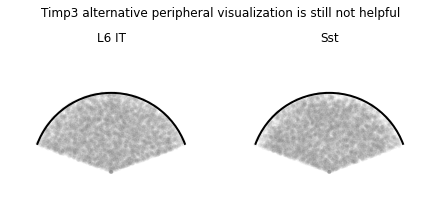

In [32]:
def hemisphere_plot(plot_df,ax,theta1=0,theta2=180):
    plot_df['angle'] = np.random.uniform(theta1/180*np.pi,theta2/180*np.pi,len(plot_df))
    plot_df['x'] = plot_df['angle'].apply(np.cos).multiply(plot_df['value'])
    plot_df['y'] = plot_df['angle'].apply(np.sin).multiply(plot_df['value'])

    ax = sns.scatterplot(
        x = 'x',
        y = 'y',
        color = 'grey',
        size = 1,
        alpha = 0.1,
        data = plot_df.sample(5000),
        ax = ax,
        legend = None,
    )
    arc = Arc(
        xy=(0, 0),
        width=2, height=2,
        angle=0, theta1=theta1, theta2=theta2,
        linewidth=2,
        facecolor='none', edgecolor='k', linestyle='solid',
    )
    ax.add_patch(arc)
    ax.axis('equal')
    ax.set_xlim([-1,1])
    ax.set_ylim([0,1])
    ax.axis('off')
    return ax
    
    
nrow,ncol = 1,2
fig,axs = plt.subplots(nrow,ncol,figsize=(6,3),constrained_layout=True)
axs = axs.flatten() if ncol*nrow > 1 else [axs]

plot_df = filt_df[filt_df['gene'].eq('Timp3')]

for i,(ont,g) in enumerate(filt_df.groupby('ontology')):
    if i+1 > ncol*nrow:
        break
        
    ax = hemisphere_plot(g,axs[i],theta1=20,theta2=160)
    ax.set_title(ont)

plt.suptitle('Timp3 alternative peripheral visualization is still not helpful')
plt.show()
plt.close()

In [ ]:
filt_df['ontology'].unique()

In [ ]:
filt_df['gene'].unique()